In [1]:
library(dplyr)
library(stringr)
library(Seurat) # Seurat v4.1.0
library(Matrix)
library(ggplot2)
library(RColorBrewer)
library(viridis)
library(ggrepel)
library(ggbeeswarm)
library(ggpubr)



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: SeuratObject

Loading required package: sp

‘SeuratObject’ was built under R 4.3.1 but the current version is
4.3.2; it is recomended that you reinstall ‘SeuratObject’ as the ABI
for R may have changed

‘SeuratObject’ was built with package ‘Matrix’ 1.6.3 but the current
version is 1.6.5; it is recomended that you reinstall ‘SeuratObject’ as
the ABI for ‘Matrix’ may have changed


Attaching package: ‘SeuratObject’


The following object is masked from ‘package:base’:

    intersect


Loading required package: viridisLite



In [2]:
group.pal = c('d30_60mer-PADRE'= '#e69f00', 'p60mer'='black')
Axis_themes <- theme(plot.title = element_text(size = 8,hjust=0.5),
                     plot.subtitle = element_text(size = 8,hjust=0.5),
                     axis.title = element_text(size = 8),
                     axis.text = element_text(size = 8,color='black'),
                     axis.text.x = element_text(size = 8, angle=45, hjust=1),                     
                     legend.text = element_text(size = 8),
                     legend.title = element_text(size = 8),
                     legend.key.size = unit(.3, 'cm'),
                     strip.text.x = element_text(size = 8),
                     strip.background = element_rect(fill=NA,linewidth=0,color='black'),
                     axis.line = element_line(linewidth = .3),
                     axis.ticks = element_line(linewidth = 0.3))

In [11]:
srat = readRDS('seurat_objects/03_multiomic_seurat.RDS')
srat

An object of class Seurat 
16497 features across 2998 samples within 2 assays 
Active assay: RNA (16493 features, 2000 variable features)
 3 layers present: counts, data, scale.data
 1 other assay present: HTO
 2 dimensional reductions calculated: pca, umap

In [12]:
metadata = srat@meta.data

In [13]:
colnames(metadata)

[1] "cell_id"                   "orig.ident"               
 [3] "nCount_RNA"                "nFeature_RNA"             
 [5] "nCount_HTO"                "nFeature_HTO"             
 [7] "HTO_classification.global" "hash.ID"                  
 [9] "barcode"                   "percent.mt"               
[11] "group"                     "contig_id_hc"             
[13] "length_hc"                 "reads_hc"                 
[15] "umis_hc"                   "v_call_hc"                
[17] "d_call_hc"                 "j_call_hc"                
[19] "locus_hc"                  "cdr1_hc"                  
[21] "cdr2_hc"                   "cdr3_hc"                  
[23] "junction_hc"               "junction_aa_hc"           
[25] "sequence_hc"               "mouse_v_score"            
[27] "contig_id_lc"              "length_lc"                
[29] "reads_lc"                  "umis_lc"                  
[31] "v_call_lc"                 "d_call_lc"                
[33] "j_call_lc"                 "locus_lc"                 
[35] "cdr1_lc"                   "cdr2_lc"                  
[37] "cdr3_lc"                   "junction_lc"              
[39] "junction_aa_lc"            "sequence_lc"              
[41] "align.score"               "animal_id"                
[43] "is.vrc01"                  "germline_hc"              
[45] "shm_count"                 "private_clone_id"         
[47] "clone_size"                "bin"                      
[49] "n_animals"                 "public_clone_id"

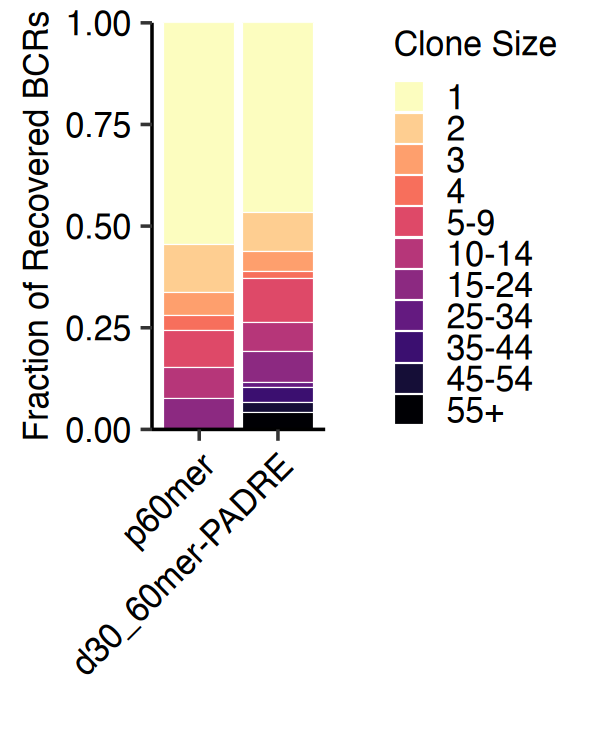

In [16]:
options(repr.plot.width=2,repr.plot.height=2.5,repr.plot.res=300  )
# Count number of cells per clonotype
metadata = metadata %>%
  mutate(bin = cut(clone_size, breaks = c(0, 1, 2, 3, 4, 9, seq(14, 55, 10), 100),include.lowest = TRUE,
                   labels = c(1,2,3,4,'5-9','10-14',paste(seq(15, 45, 10), seq(24, 55, 10), sep = "-"), "55+")))

metadata %>%
ggplot(aes(x = group, fill = bin)) + theme_classic() +
geom_bar(position = 'fill', color = 'white', linewidth = 0.1) +
labs(x = '', y = 'Fraction of Recovered BCRs', fill = 'Clone Size') +
scale_fill_viridis(discrete = TRUE, direction = -1, option = 'magma', na.value = 'grey') +
guides(fill = guide_legend(keywidth = 0.5, keyheight = 0.2, ncol = 1)) +
scale_y_continuous(expand = c(0, 0)) +
Axis_themes

out = 'figures/barplot_clonal_expansion.pdf'
ggsave(out,device='pdf', height = 2.5, width = 2,
       dpi = 300,useDingbats = FALSE)

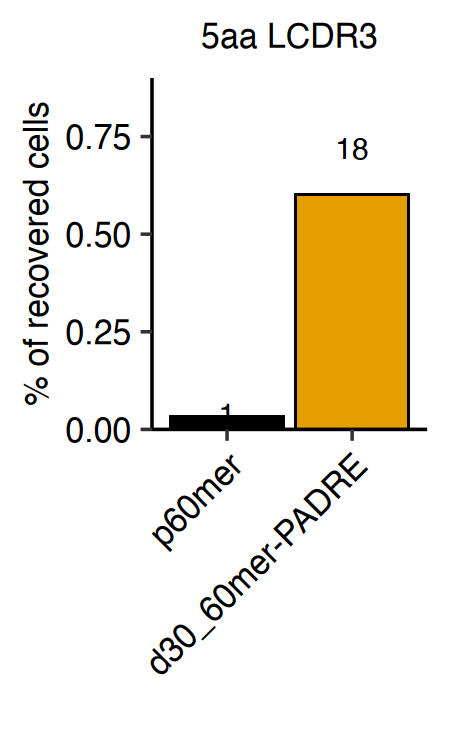

In [34]:
options(repr.plot.width=1.5,repr.plot.height=2.5,repr.plot.res=300  )
metadata %>% 
count(group,is.vrc01) %>% group_by(group,percent=n/sum(n)*100) %>% filter(is.vrc01) %>%
ggplot(aes(x=group,y = percent, fill=group)) + theme_classic() +
geom_bar(stat = "identity",color='black',linewidth=0.25) +
geom_text( aes(label = n),position = position_stack(vjust = 1.2), size = 2.5, color = "black") +
scale_y_continuous(expand=c(0,0),limits = c(0,0.9)) +
scale_fill_manual(values = group.pal) +
labs( x = "",y = "% of recovered cells",fill = "5aa LCDR3", title='5aa LCDR3') +
Axis_themes +
theme(legend.position = "none")

out = 'figures/barplot_vrc01.pdf'
ggsave(out,device='pdf', height = 2.5, width = 1.5,
       dpi = 300,useDingbats = FALSE)

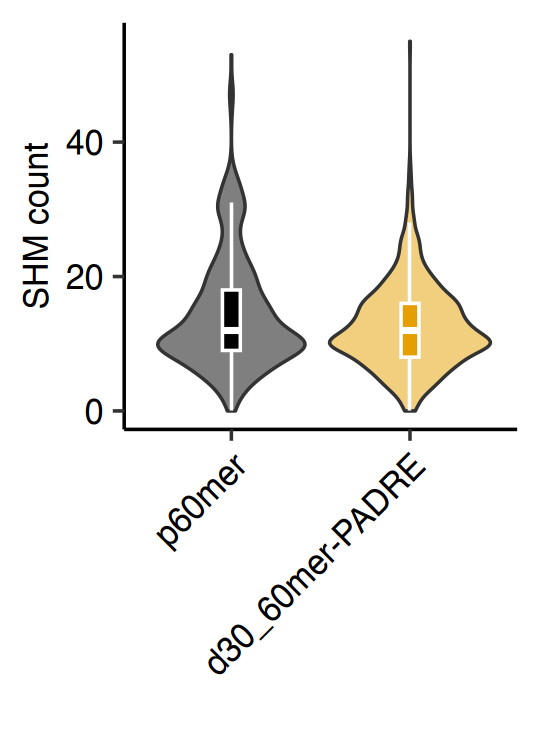

In [23]:
options(repr.plot.res=300, repr.plot.height=2.5, repr.plot.width=1.8)
metadata %>% 
ggplot(aes(x=group,y=shm_count))+ theme_classic() +
geom_violin(aes(fill=group),alpha=0.5,linewidth=0.3)+
geom_boxplot(aes(fill=group),color='white',width=0.1,outlier.shape=NA,linewidth=0.3)+
Axis_themes+
scale_fill_manual(values = group.pal)+
labs(x='',y='SHM count')+
theme(legend.position = "none")

out = 'figures/violinplot_shm.pdf'
ggsave(out,device='pdf', height = 2.5, width = 1.8,
       dpi = 300,useDingbats = FALSE)


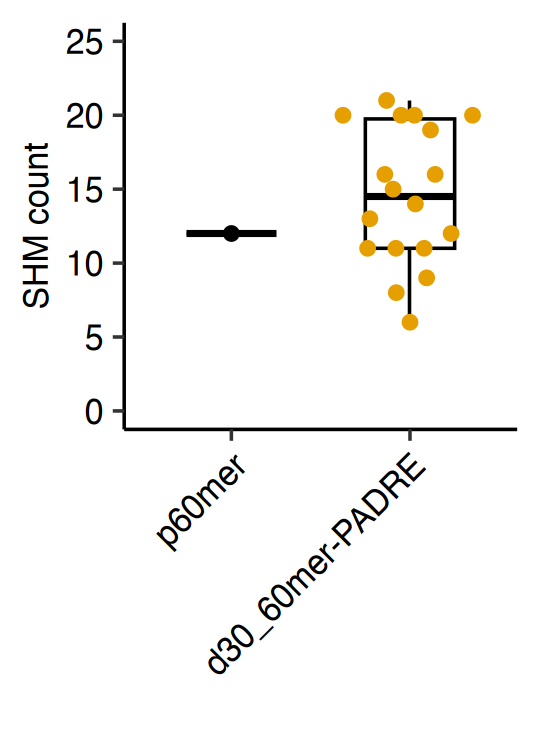

In [26]:
options(repr.plot.res=300, repr.plot.height=2.5, repr.plot.width=1.8)
metadata %>% filter(is.vrc01) %>%
ggplot(aes(x=group,y=shm_count))+ theme_classic() +
geom_boxplot(fill='white',color='black',width=0.5,outlier.shape=NA,linewidth=0.3)+
geom_quasirandom(aes(color=group),size=1)+
scale_y_continuous(limits=c(0,25))+
Axis_themes+
scale_color_manual(values = group.pal)+
labs(x='',y='SHM count')+
theme(legend.position = "none")

out = 'figures/boxplot_vrc01_shm.pdf'
ggsave(out,device='pdf', height = 2.5, width = 1.8,
       dpi = 300,useDingbats = FALSE)


In [18]:
library(ggseqlogo)

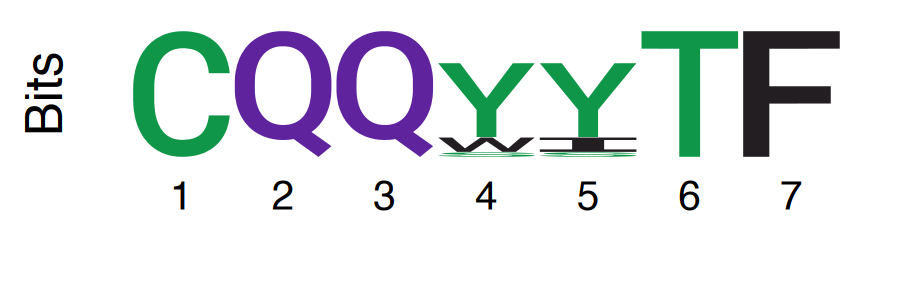

In [20]:
# logo plot of vrc01 class ligth chains 

options(repr.plot.width=3,repr.plot.height=1,repr.plot.res=300  )
df4gg = metadata %>% filter(is.vrc01) 
ggseqlogo(df4gg$junction_aa_lc, method = "bits") + 
theme(legend.key.size = unit(.3, 'cm'),legend.position = "none",axis.text.y=element_blank())

out = 'figures/logoplot_vrc01_lcdr3.pdf'
ggsave(out,device='pdf', height = 1, width = 3,
       dpi = 300,useDingbats = FALSE)